In [67]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from matplotlib.colors import LinearSegmentedColormap


In [68]:
features = pd.read_csv('data/Table_EV6/Table_EV6.tsv', sep='\t')
features = features.iloc[:, 4:]
features = features[[col for col in features.columns if "MiRNA" not in col]]
features = features[[col for col in features.columns if "RBP" not in col]]
print(features.columns.to_list())  
print(features.head())  

['Codon_AAA', 'Codon_AAC', 'Codon_AAG', 'Codon_AAU', 'Codon_ACA', 'Codon_ACC', 'Codon_ACG', 'Codon_ACU', 'Codon_AGA', 'Codon_AGC', 'Codon_AGG', 'Codon_AGU', 'Codon_AUA', 'Codon_AUC', 'Codon_AUG', 'Codon_AUU', 'Codon_CAA', 'Codon_CAC', 'Codon_CAG', 'Codon_CAU', 'Codon_CCA', 'Codon_CCC', 'Codon_CCG', 'Codon_CCU', 'Codon_CGA', 'Codon_CGC', 'Codon_CGG', 'Codon_CGU', 'Codon_CUA', 'Codon_CUC', 'Codon_CUG', 'Codon_CUU', 'Codon_GAA', 'Codon_GAC', 'Codon_GAG', 'Codon_GAU', 'Codon_GCA', 'Codon_GCC', 'Codon_GCG', 'Codon_GCU', 'Codon_GGA', 'Codon_GGC', 'Codon_GGG', 'Codon_GGU', 'Codon_GUA', 'Codon_GUC', 'Codon_GUG', 'Codon_GUU', 'Codon_UAC', 'Codon_UAU', 'Codon_UCA', 'Codon_UCC', 'Codon_UCG', 'Codon_UCU', 'Codon_UGC', 'Codon_UGG', 'Codon_UGU', 'Codon_UUA', 'Codon_UUC', 'Codon_UUG', 'Codon_UUU', 'Kozak_P_6.A', 'Kozak_P_6.C', 'Kozak_P_6.U', 'Kozak_P_5.A', 'Kozak_P_5.G', 'Kozak_P_5.U', 'Kozak_P_4.A', 'Kozak_P_4.G', 'Kozak_P_4.U', 'Kozak_P_3.C', 'Kozak_P_3.G', 'Kozak_P_3.U', 'Kozak_P_2.A', 'Kozak_P_2.

In [69]:
ptr = pd.read_csv('data/Table_EV3/Table_EV3.tsv', sep='\t')

ptr = ptr[[col for col in ptr.columns if "PTR" in col]]

print(ptr.shape)
print(ptr.head()) 

(11575, 29)
  Adrenal_PTR Appendices_PTR Brain_PTR Colon_PTR Duodenum_PTR Endometrium_PTR  \
0          NA          8.277        NA        NA           NA              NA   
1          NA             NA        NA     5.135        5.371              NA   
2       6.290          6.328     5.948     5.811        6.068           5.383   
3          NA             NA     3.995        NA           NA              NA   
4       3.843          4.601        NA        NA           NA              NA   

  Esophagus_PTR Fallopiantube_PTR Fat_PTR Gallbladder_PTR  ... Rectum_PTR  \
0            NA             7.841      NA              NA  ...         NA   
1            NA                NA      NA           5.425  ...      5.147   
2         5.881             6.119   6.410           5.828  ...      6.081   
3         4.129                NA      NA              NA  ...         NA   
4         4.013             3.683      NA              NA  ...      4.731   

  Salivarygland_PTR Smallintestine_PTR

In [70]:
# ptr = ptr.replace(r'^\s*NA\s*$', 0, regex=True)
# ptr = ptr.apply(pd.to_numeric, errors='coerce').fillna(0)

# Apply numeric conversion column-wise
ptr = ptr.apply(pd.to_numeric, errors='coerce')

# Create a 1D boolean mask: keep rows with no NaNs
valid_idx = ptr.notna().all(axis=1)

# Now safely filter
ptr = ptr[valid_idx]
features = features.loc[valid_idx]
print(ptr.shape)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
coefs = []
intercepts = []

for train_idx, test_idx in kf.split(features):
    X_train, Y_train = features.iloc[train_idx], ptr.iloc[train_idx]
    model = LinearRegression()
    model.fit(X_train, Y_train)
    coefs.append(model.coef_)
    intercepts.append(model.intercept_)

# Convert to arrays for further analysis
coefs = np.array(coefs)         # shape: (10, n_targets, n_features)
intercepts = np.array(intercepts)  # shape: (10, n_targets)



(4506, 29)


In [71]:
pred = model.predict(features)  # or use new_features for new data
print(pred)

[[5.47779268 5.22650579 5.39251728 ... 5.52682506 5.15428631 5.31521294]
 [4.93452054 4.39697922 4.75119825 ... 4.94773859 4.66899081 4.67713338]
 [5.7739858  5.27786157 5.5700667  ... 5.61418907 5.33792108 5.37764296]
 ...
 [5.04391611 4.95550203 5.20345963 ... 4.80453651 4.92731806 4.94215971]
 [5.58850809 5.52657761 5.69323962 ... 5.91332789 5.79249773 5.69666906]
 [4.72735132 4.60280387 4.86424579 ... 4.63998403 4.88072107 4.71706991]]


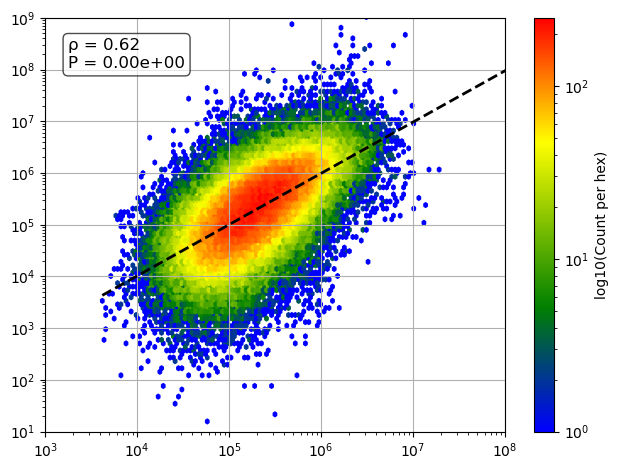

In [72]:
predf = pred.flatten()
ptrf = ptr.values.flatten()
rho, pval = spearmanr(predf, ptrf)


pred_orig = 10**predf
ptr_orig = 10**ptrf

colors = [
    (0.0, "blue"),
    (0.3, "green"),
    (0.7, "yellow"),
    (1  , "red"),
]

custom_cmap = LinearSegmentedColormap.from_list("blue_yellow_red", colors)

hb =plt.hexbin(pred_orig, ptr_orig,gridsize=100, 
           xscale = 'log',yscale = 'log',cmap=custom_cmap, bins = 'log' ,mincnt=1  )

cb = plt.colorbar(hb)
cb.set_label('log10(Count per hex)')

plt.xlim(1e3, 1e8)
plt.ylim(10, 1e9)

# Regression line on log-log scale using log10 of plotted data
m, b = np.polyfit(predf, ptrf, 1)
x_fit = np.linspace(predf.min(), ptrf.max(), 100)
y_fit = m * x_fit + b
plt.plot(10**x_fit, 10**y_fit, color='black', linestyle='--', linewidth=2, label='Fit line')

# Show Pearson correlation (original scale)
textstr = f'ρ = {rho:.2f}\nP = {pval:.2e}'
plt.text(
    0.05, 0.95, textstr,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
)


plt.grid()
plt.tight_layout()
plt.show()